In [ ]:
from typing import TypedDict,Literal
from langgraph.graph import StateGraph, START, END
from pydantic import BaseModel,Field


In [ ]:
import os
from langchain_google_genai import ChatGoogleGenerativeAI

# 1. Set your NEW API key
os.environ["GOOGLE_API_KEY"] = 'AIzaSyANyksWpr2ptAdCmQz4XXXXXXXXXXXXXX'

# 2. Use the correct model string for the current API
# Note: Using "gemini-1.5-flash" is the best path for LangGraph
model = ChatGoogleGenerativeAI(
    model="gemini-2.5-pro", 
    temperature=0
)

# 3. Test it before running the workflow
try:
    response = model.invoke("How far is the moon from the earth?")
    print(response.content)
except Exception as e:
    print(f"Error: {e}")

The Moon orbits the Earth at an average distance of about **384,400 kilometers (≈238,900 miles)**.  

Because its orbit is elliptical, the actual distance varies:

- **Perigee** (closest approach): roughly **363,300 km** (≈225,600 mi)  
- **Apogee** (farthest point): roughly **405,500 km** (≈252,000 mi)

So, while the average separation is ~384 thousand kilometers, the Moon can be a bit nearer or farther depending on where it is in its orbit.


In [196]:
from pydantic import BaseModel, Field
from typing import Literal

class SentimentSchema(TypedDict):
    sentiment: Literal["positive", "negative"]

    





In [197]:
class ReviewState(TypedDict):

    review: str
    sentiment: Literal["positive", "negative"]
    diagnosis: dict
    response: str
    

In [198]:
class SentimentSchema(BaseModel):

    sentiment: Literal["positive", "negative"] = Field(description='Sentiment of the review')

In [199]:
class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description='The category of issue mentioned in the review')
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(description='The emotional tone expressed by the user')
    urgency: Literal["low", "medium", "high"] = Field(description='How urgent or critical the issue appears to be')

In [ ]:
structured_model = model.with_structured_output(SentimentSchema)
structured_model2=model.with_structured_output(DiagnosisSchema)

AttributeError: 'str' object has no attribute 'with_structured_output'

In [ ]:
def find_sentiment(state: ReviewState):

    prompt = f'For the following review find out the sentiment \n {state["review"]}'
    sentiment = structured_model.invoke(prompt).sentiment

    return {'sentiment': sentiment}

def check_sentiment(state: ReviewState) -> Literal["positive_response", "run_diagnosis"]:

    if state['sentiment'] == 'positive':
        return 'positive_response'
    else:
        return 'run_diagnosis'
    
def positive_response(state: ReviewState):

    prompt = f"""Write a  warm thank-you only one  message in response to this review:
    \n\n\"{state['review']}\"\n
Also, kindly ask the user to leave feedback on our website."""
    
    response = model.invoke(prompt).content

    return {'response': response}

def run_diagnosis(state: ReviewState):

    prompt = f"""Diagnose this negative review:\n\n{state['review']}\n"
    "Return issue_type, tone, and urgency.
"""
    response = structured_model2.invoke(prompt)

    return {'diagnosis': response.model_dump()}

def negative_response(state: ReviewState):

    diagnosis = state['diagnosis']

    prompt = f"""You are a support assistant.
The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}', and marked urgency as '{diagnosis['urgency']}'.
Write an empathetic, helpful resolution message.
"""
    response = model.invoke(prompt).content

    return {'response': response}

In [ ]:
graph = StateGraph(ReviewState)

graph.add_node('find_sentiment', find_sentiment)
graph.add_node('positive_response', positive_response)
graph.add_node('run_diagnosis', run_diagnosis)
graph.add_node('negative_response', negative_response)

graph.add_edge(START, 'find_sentiment')

graph.add_conditional_edges('find_sentiment', check_sentiment)

graph.add_edge('positive_response', END)

graph.add_edge('run_diagnosis', 'negative_response')
graph.add_edge('negative_response', END)

workflow = graph.compile()

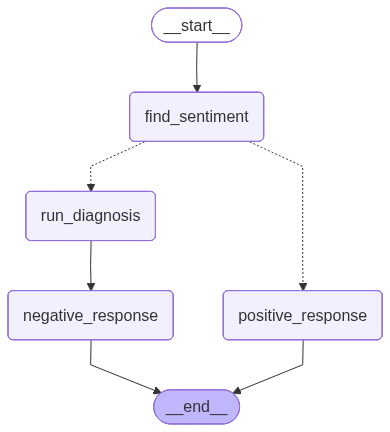

In [ ]:
workflow

In [ ]:
initial_state = {
    'review': "ui is very good"}

workflow.invoke(initial_state)


ChatGoogleGenerativeAIError: Error calling model 'gemini-2.5-pro' (RESOURCE_EXHAUSTED): 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 0, model: gemini-2.5-pro\n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 0, model: gemini-2.5-pro\n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_input_token_count, limit: 0, model: gemini-2.5-pro\n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_input_token_count, limit: 0, model: gemini-2.5-pro\nPlease retry in 27.991371313s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerDayPerProjectPerModel-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 'gemini-2.5-pro'}}, {'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions': {'model': 'gemini-2.5-pro', 'location': 'global'}}, {'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_input_token_count', 'quotaId': 'GenerateContentInputTokensPerModelPerMinute-FreeTier', 'quotaDimensions': {'model': 'gemini-2.5-pro', 'location': 'global'}}, {'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_input_token_count', 'quotaId': 'GenerateContentInputTokensPerModelPerDay-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 'gemini-2.5-pro'}}]}, {'@type': 'type.googleapis.com/google.rpc.RetryInfo', 'retryDelay': '27s'}]}}